In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from sklearn.metrics import accuracy_score, adjusted_rand_score, silhouette_score, davies_bouldin_score, adjusted_mutual_info_score
from sklearn.decomposition import PCA
import pylab as pl
from sklearn.feature_selection import SelectKBest

In [2]:
green_data = pd.read_csv('../green_consensus.csv')
hinselmann_data = pd.read_csv('../hinselmann_consensus.csv')
schiller_data = pd.read_csv('../schiller_consensus.csv')

hinselmann_data['hinselmann'] = 1
hinselmann_data['schiller'] = 0
schiller_data['hinselmann'] = 0
schiller_data['schiller'] = 1

data = pd.concat([hinselmann_data, schiller_data])
data_frac = data.sample(frac=0.1, random_state=42)
data = data.drop(index=data_frac.index)
data_frac = data_frac.reset_index(drop=True)
data = data.reset_index(drop=True)

In [3]:
data.columns

Index(['cervix_area', 'os_area', 'walls_area', 'speculum_area',
       'artifacts_area', 'cervix_artifacts_area', 'os_artifacts_area',
       'walls_artifacts_area', 'speculum_artifacts_area',
       'cervix_specularities_area', 'os_specularities_area',
       'walls_specularities_area', 'speculum_specularities_area',
       'specularities_area', 'area_h_max_diff', 'rgb_cervix_r_mean',
       'rgb_cervix_r_std', 'rgb_cervix_r_mean_minus_std',
       'rgb_cervix_r_mean_plus_std', 'rgb_cervix_g_mean', 'rgb_cervix_g_std',
       'rgb_cervix_g_mean_minus_std', 'rgb_cervix_g_mean_plus_std',
       'rgb_cervix_b_mean', 'rgb_cervix_b_std', 'rgb_cervix_b_mean_minus_std',
       'rgb_cervix_b_mean_plus_std', 'rgb_total_r_mean', 'rgb_total_r_std',
       'rgb_total_r_mean_minus_std', 'rgb_total_r_mean_plus_std',
       'rgb_total_g_mean', 'rgb_total_g_std', 'rgb_total_g_mean_minus_std',
       'rgb_total_g_mean_plus_std', 'rgb_total_b_mean', 'rgb_total_b_std',
       'rgb_total_b_mean_minus_std'

In [4]:
classes = ['experts::{}'.format(i) for i in range(5)]
classes.extend(['consensus', 'hinselmann', 'schiller'])
X = data.drop(columns=classes)
X_test = data_frac.drop(columns=classes)
Q1 = X.quantile(0.05)
Q3 = X.quantile(0.95)
IQR = Q3 - Q1
color_cols = [col for col in X.columns if ('cervix' in col and '_v_' in col) and (('hsv' in col))]
print(color_cols)
X = X[color_cols]
X_test = X_test[color_cols]

#X = X[~((X < (Q1 - 1.5 * IQR)) |(X > (Q3 + 1.5 * IQR))).any(axis=1)]


y = data.iloc[X.index]['consensus']
y_dataset = data.iloc[X.index][['schiller', 'hinselmann']].idxmax(axis=1)
y_test = data_frac[['schiller', 'hinselmann']].idxmax(axis=1)
y_dataset = y_dataset.map({'hinselmann': 0, 'schiller': 1})
y_test = y_test.map({'hinselmann': 0, 'schiller': 1})
y_dataset = y_dataset.reset_index(drop=True)
pca = PCA(0.95).fit(X)
X = pca.transform(X)
X_test = pca.transform(X_test)

['cervix_area', 'cervix_artifacts_area', 'cervix_specularities_area', 'rgb_cervix_r_mean', 'rgb_cervix_r_std', 'rgb_cervix_r_mean_minus_std', 'rgb_cervix_r_mean_plus_std', 'rgb_cervix_g_mean', 'rgb_cervix_g_std', 'rgb_cervix_g_mean_minus_std', 'rgb_cervix_g_mean_plus_std', 'rgb_cervix_b_mean', 'rgb_cervix_b_std', 'rgb_cervix_b_mean_minus_std', 'rgb_cervix_b_mean_plus_std', 'hsv_cervix_h_mean', 'hsv_cervix_h_std', 'hsv_cervix_s_mean', 'hsv_cervix_s_std', 'hsv_cervix_v_mean', 'hsv_cervix_v_std', 'fit_cervix_hull_rate', 'fit_cervix_hull_total', 'fit_cervix_bbox_rate', 'fit_cervix_bbox_total', 'dist_to_center_cervix']


In [5]:
y_dataset.shape[0]

155

In [6]:
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
X_test = scaler.transform(X_test)

In [7]:
def kMeans(X, n_clusters=2):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X)
    
    predicted = kmeans.predict(X)
    centers = kmeans.cluster_centers_
    labels = kmeans.labels_
    return labels, kmeans

def hierarchical(X, n_clusters=2):
    ac = SpectralClustering(n_clusters=n_clusters)
    ac.fit(X)

    labels = ac.labels_
    return labels


In [8]:
kpred, kmeans = kMeans(X, 2)

In [9]:
print(adjusted_mutual_info_score(y_dataset, kpred))
print(adjusted_rand_score(y_dataset, kpred))


0.02787332558023921
0.039121159379266676


/home/francisconeves/anaconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


In [10]:
kpred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0,
       1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0], dtype=int32)

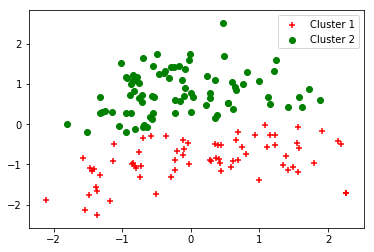

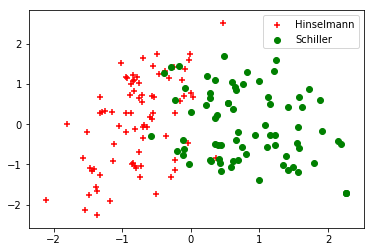

In [11]:
for i in range(0, X.shape[0]):
    if kpred[i] == 0:
        c1 = pl.scatter(X[i,0], X[i,1], c='r', marker="+")
    elif kpred[i] == 1:
        c2 = pl.scatter(X[i,0], X[i,1], c='g', marker="o")
    elif kpred[i] == 2:
        c3 = pl.scatter(X[i,0], X[i,1], c='b', marker="*")
        
#pl.legend([c1, c2, c3], ['Cluster 1', 'Cluster 2', 'Cluster 3'])
pl.legend([c1, c2], ['Cluster 1', 'Cluster 2'])
pl.show()

for i in range(0, X.shape[0]):
    if y_dataset[i] == 0:
        c1 = pl.scatter(X[i,0], X[i,1], c='r', marker="+")
    elif y_dataset[i] == 1:
        c2 = pl.scatter(X[i,0], X[i,1], c='g', marker="o")
    elif y_dataset[i] == 2:
        c3 = pl.scatter(X[i,0], X[i,1], c='b', marker="*")
        
#pl.legend([c1, c2, c3], ['Green', 'Hinselmann', 'Schiller'])
pl.legend([c1, c2], ['Hinselmann', 'Schiller'])
pl.show()

In [12]:
pred = kmeans.predict(X_test)

In [13]:
pred

array([1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1],
      dtype=int32)

In [14]:
y_test.ravel()

array([1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0])

In [15]:
adjusted_rand_score(y_test, pred)

0.016703176341730536